# Plant Seedlings Challenge

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from shutil import copyfile, copy as fcopy

import os, sys

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.preprocessing import LabelEncoder

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.set_device(0)

In [9]:
PATH = "data/"
sz = 224
arch = resnext101_64
bs = 58

In [8]:
!ls {PATH}

images
labels.csv
models
sample_submission.csv
test
tmp
train


In [23]:
images_dir = f'{PATH}images'

In [25]:
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [26]:
train_directory = f'{PATH}train/'

columns = ['file_name', 'label']
data = []


for blabel in os.listdir(os.fsencode(train_directory)):
    label = blabel.decode('ascii')
    label_dir = f'{train_directory}{label}'
    for bfile in os.listdir(os.fsencode(label_dir)):
        file = bfile.decode('ascii')
        file_ext = '.png'
        if file.endswith(file_ext):
            file_name = file[:-len(file_ext)]
            data.append([file_name, label])
            fcopy(f'{train_directory}{label}/{file}', images_dir)
            
data = np.array(data)
data

array([['0050f38b3', 'Black-grass'],
       ['0183fdf68', 'Black-grass'],
       ['0260cffa8', 'Black-grass'],
       ...,
       ['fed9406b2', 'Sugar beet'],
       ['fef5e7066', 'Sugar beet'],
       ['ffa401155', 'Sugar beet']], dtype='<U25')

In [27]:
df = pd.DataFrame(data, columns=columns)

In [28]:
df.pivot_table(index="label", aggfunc=len)

file_name
label                               
Black-grass                      263
Charlock                         390
Cleavers                         287
Common Chickweed                 611
Common wheat                     221
Fat Hen                          475
Loose Silky-bent                 654
Maize                            221
Scentless Mayweed                516
Shepherds Purse                  231
Small-flowered Cranesbill        496
Sugar beet                       385

In [29]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
label_csv = f'{PATH}labels.csv'
df.to_csv(label_csv, index=False)

In [31]:
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [32]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'images', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)
    
    return data if sz > 300 else data.resize(340, 'tmp') 

In [33]:
data = get_data(sz, bs)

In [44]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [37]:
lrf=learn.lr_find()

 70%|██████████████████████████████████████████▌                  | 46/66 [00:02<00:20,  1.03s/it, loss=2.25]


In [38]:
learn.sched.plot_lr()

In [39]:
learn.sched.plot()

In [45]:
learn.precompute = True
learn.fit(0.03, 5)

epoch      trn_loss   val_loss   accuracy                                                                    
    0      1.043972   0.55811    0.797895  
    1      0.697498   0.476743   0.827368                                                                    
    2      0.519903   0.358372   0.858947                                                                    
    3      0.424287   0.39503    0.854737                                                                    
    4      0.342554   0.338479   0.878947                                                                    



[array([0.33848]), 0.8789473676681518]

In [46]:
learn.precompute = False

In [47]:
learn.fit(0.03, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                    
    0      0.352494   0.306371   0.887368  
    1      0.34126    0.309173   0.887368                                                                    
    2      0.337209   0.295191   0.884211                                                                    
    3      0.324359   0.281706   0.898947                                                                    
    4      0.321568   0.281531   0.889474                                                                    



[array([0.28153]), 0.889473690359216]

In [48]:
learn.save('224_pre')

In [49]:
learn.load('224_pre')

## Increase size

In [50]:
learn.set_data(get_data(299, int(bs * (3/4)) )) 
learn.freeze()

In [51]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [52]:
learn.fit(0.03, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                    
    0      0.391403   0.239463   0.914737  
    1      0.383588   0.244417   0.906316                                                                    
    2      0.299947   0.220178   0.911579                                                                    
    3      0.360931   0.25675    0.914737                                                                    
    4      0.309365   0.239204   0.910526                                                                    
    5      0.265975   0.201841   0.924211                                                                    
    6      0.214086   0.199499   0.921053                                                                    



[array([0.1995]), 0.9210526295084702]

In [53]:
learn.save('299_pre')

In [56]:
learn.load('299_pre')

In [65]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9347368421052632

In [66]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 28   0   0   0   0   0   2   0  18   0   0   0]
 [  1  70   0   0   0   1   0   1   0   1   0   0]
 [  0   0 100   0   0   0   0   0   0   0   0   0]
 [  0   0   0  70   0   1   2   4   0   0   1   0]
 [  0   0   0   2  58   0   0   0   0   0   1   0]
 [  0   0   0   0   0 140   0   0   0   0   3   1]
 [  1   0   0   1   0   0  37   1   1   1   0   0]
 [  0   1   0   0   0   1   1  75   0   0   0   1]
 [  5   0   0   0   0   0   0   0 129   0   0   0]
 [  0   0   0   1   0   0   3   0   0  40   1   0]
 [  0   0   0   0   0   2   1   0   0   0  97   0]
 [  0   0   0   0   0   0   0   0   0   0   1  44]]


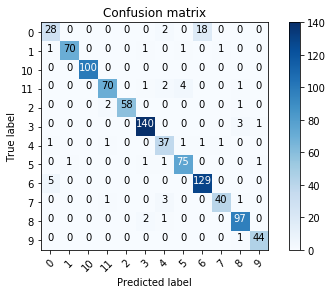

In [67]:
plot_confusion_matrix(cm, data.classes)

In [10]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

NameError: name 'learn' is not defined

## Visualize

In [68]:
data.classes

['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']

In [69]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(950, 12)

In [70]:
log_preds[0]

array([-14.59972, -17.81854, -20.80273,  -3.68093, -10.03442,  -0.0332 , -15.47194,  -4.91723, -14.1019 ,
       -13.79524,  -9.29122, -15.10149], dtype=float32)

In [71]:
def plotMostCorrectAndIncorrectCategories(cat):
    preds = np.argmax(log_preds, axis=1)
    probs = np.exp(log_preds[:,cat])        

    def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
    def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

    def plots(ims, figsize=(12,6), rows=1, titles=None):
        f = plt.figure(figsize=figsize)
        for i in range(len(ims)):
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
            sp.axis('Off')
            if titles is not None: sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i])

    def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

    def plot_val_with_title(idxs, title):
        imgs = [load_img_id(data.val_ds,x) for x in idxs]
        title_probs = [probs[x] for x in idxs]
        print(title)
        return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

    def most_by_mask(mask, mult):
        idxs = np.where(mask)[0]
        return idxs[np.argsort(mult * probs[idxs])[:4]]

    def most_by_correct(y, is_correct): 
        mult = -1 if (y==1)==is_correct else 1
        return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)
    
    label = label_encoder.inverse_transform([cat])[0]
    plot_val_with_title(most_by_correct(cat, True), f'Most correct {label}')
    plot_val_with_title(most_by_correct(cat, False), f'Most incorrect {label}')

Most correct Black-grass
Most incorrect Black-grass


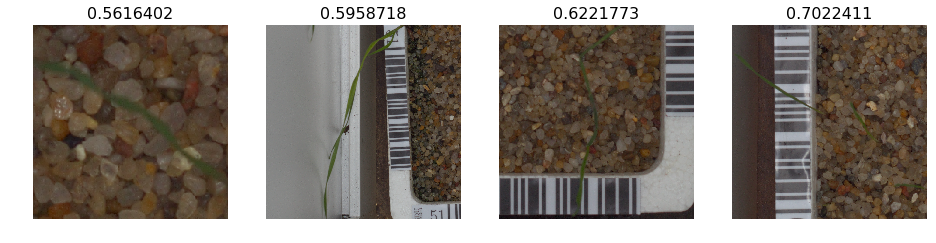

In [72]:
plotMostCorrectAndIncorrectCategories(0)

In [281]:
plotMostCorrectAndIncorrectCategories(1)

Most correct Charlock
Most incorrect Charlock


Most correct Cleavers
Most incorrect Cleavers


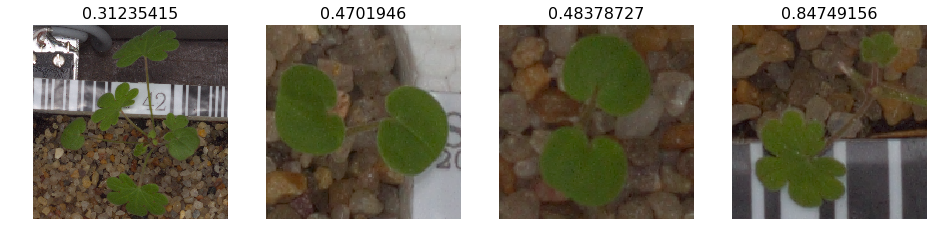

In [282]:
plotMostCorrectAndIncorrectCategories(2)

Most correct Common Chickweed
Most incorrect Common Chickweed


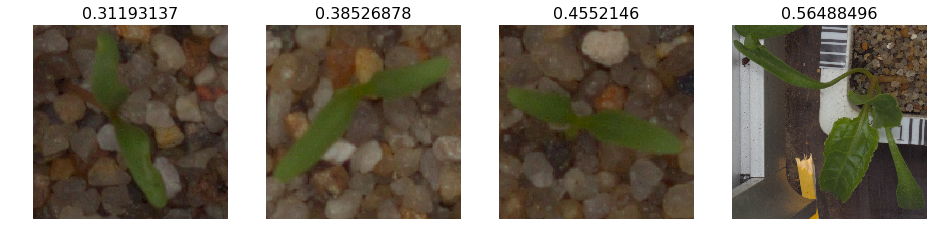

In [283]:
plotMostCorrectAndIncorrectCategories(3)

Most correct Common wheat
Most incorrect Common wheat


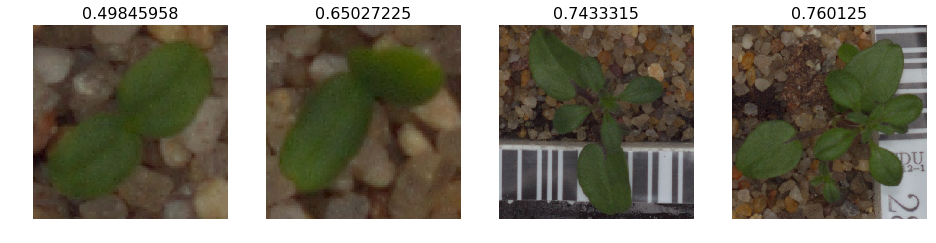

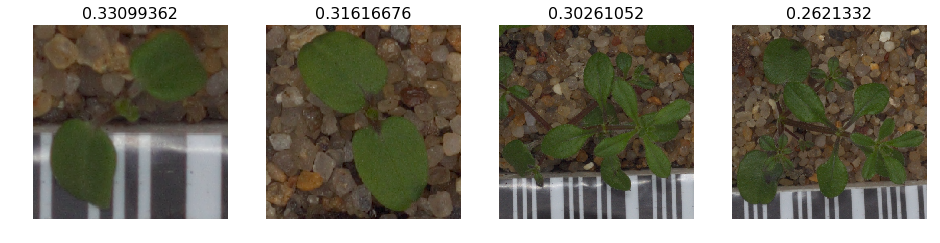

In [284]:
plotMostCorrectAndIncorrectCategories(4)

Most correct Fat Hen
Most incorrect Fat Hen


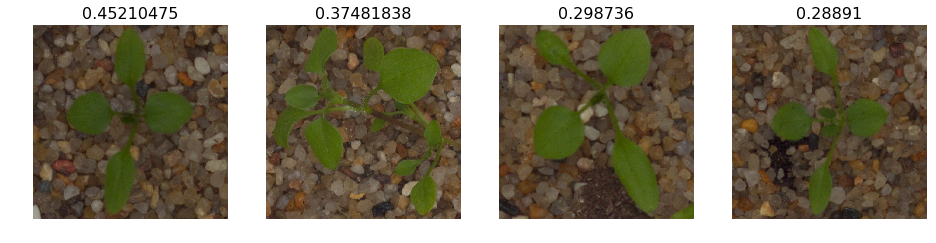

In [285]:
plotMostCorrectAndIncorrectCategories(5)

Most correct Loose Silky-bent
Most incorrect Loose Silky-bent


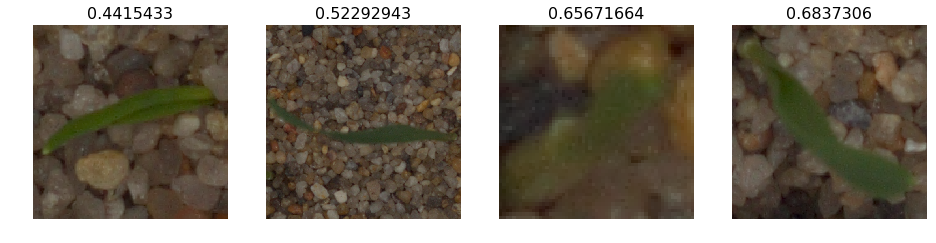

In [286]:
plotMostCorrectAndIncorrectCategories(6)

In [287]:
plotMostCorrectAndIncorrectCategories(7)

Most correct Maize
Most incorrect Maize


Most correct Scentless Mayweed
Most incorrect Scentless Mayweed


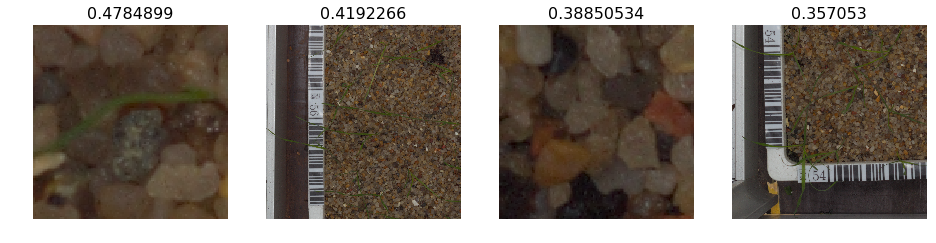

In [288]:
plotMostCorrectAndIncorrectCategories(8)

Most correct Shepherds Purse
Most incorrect Shepherds Purse


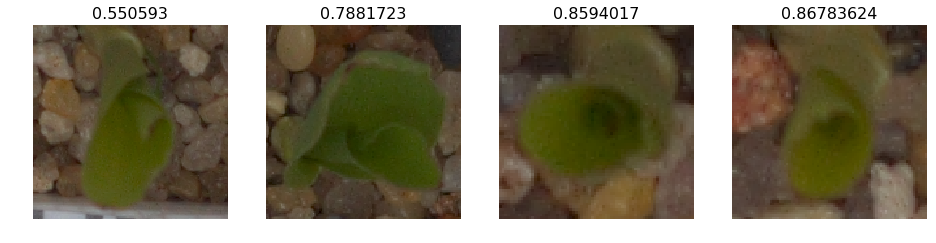

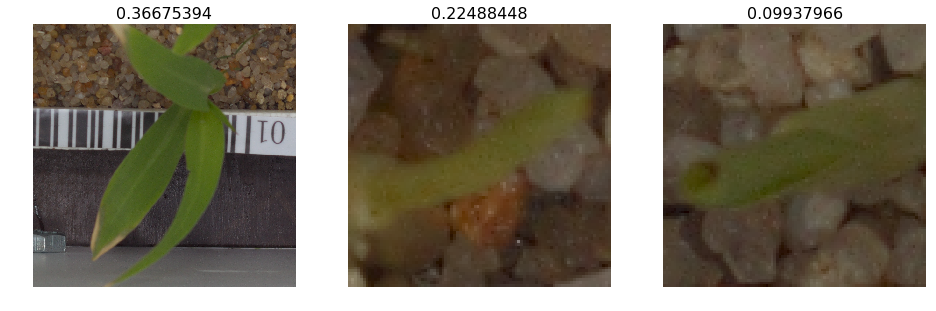

In [289]:
plotMostCorrectAndIncorrectCategories(9)

Most correct Small-flowered Cranesbill
Most incorrect Small-flowered Cranesbill


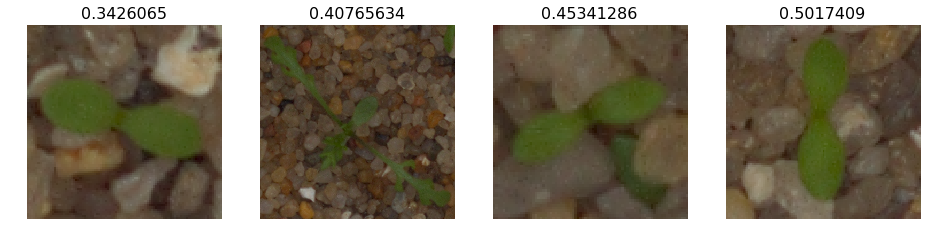

In [292]:
plotMostCorrectAndIncorrectCategories(10)

Most correct Sugar beet
Most incorrect Sugar beet


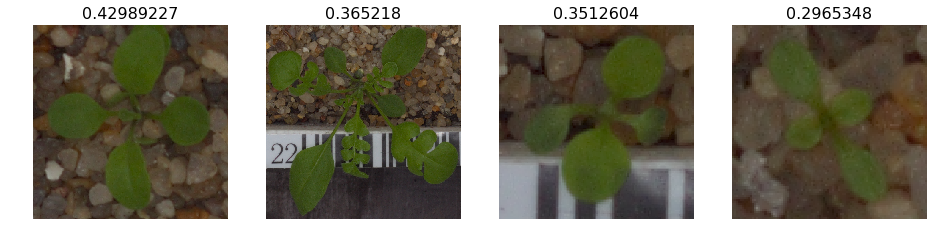

In [293]:
plotMostCorrectAndIncorrectCategories(11)